# Stage 3: NLOS Bias Prediction
## Multi-Model Pipeline — Single-Bounce Ranging Error Mitigation

**Purpose**: Given a single-bounce NLOS signal (filtered by Stage 2), predict the **NLOS bias** — the extra path length caused by the signal reflecting off a surface instead of traveling directly.

**Why this matters**: In single-bounce NLOS, the UWB measures the reflected path (d1 + d2) instead of the true direct distance. By predicting the bias, we can correct the measurement:
```
d_corrected = d_UWB - predicted_bias
```

**Ground truth** (physically measured):
| Setup | d_direct | d1+d2 (bounce) | Bias = (d1+d2) - d_direct |
|-------|----------|----------------|---------------------------|
| 7.79m | 7.79m | 12.79m | **5.00m** |
| 10.77m | 10.77m | 16.09m | **5.32m** |
| 14m | 14.00m | 16.80m | **2.80m** |

**Features**: Same 6 CIR-derived physics features as Stage 2.

**Architecture**: Random Forest Regressor — physics features are tabular, small dataset. Tree-based ensembles handle this natively.

**Pipeline**: Stage 1 (LNN → LOS/NLOS) → Stage 2 (RF → single/multi bounce) → **Stage 3 (RF → NLOS bias → corrected distance)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.signal import find_peaks
from scipy.stats import kurtosis as scipy_kurtosis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os

# ==========================================
# CONFIGURATION
# ==========================================
CONFIG = {
    # ROI alignment (same as Stage 1)
    "search_start": 740,
    "search_end": 890,
    # Peak detection (same as Stage 2)
    "peak_prominence": 0.20,
    "peak_min_distance": 5,
    # Single-bounce filter (same as Stage 2)
    "single_bounce_max_peaks": 2,
    # Random Forest
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    # Split
    "test_ratio": 0.30,
    "seed": 42,
}

# Num_Peaks excluded: same as Stage 2 (it is the auto-label source for bounce classification).
# These 5 features describe CIR shape without counting peaks.
FEATURE_NAMES = [
    "Kurtosis", "Rise_Time", "RMS_Delay_Spread",
    "Mean_Excess_Delay", "Power_Ratio"
]

np.random.seed(CONFIG["seed"])
print(f"Config: {CONFIG}")

Config: {'search_start': 740, 'search_end': 890, 'peak_prominence': 0.2, 'peak_min_distance': 5, 'single_bounce_max_peaks': 2, 'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 2, 'test_ratio': 0.3, 'seed': 42}


---
## Section 2: Data Loading, Feature Extraction & Target Assignment

1. Load NLOS samples from training dataset
2. Extract 6 CIR-derived physics features (same as Stage 2)
3. Filter to **single-bounce only** using peak count auto-labeling
4. Target: **NLOS bias** = (d1+d2) - d_direct, physically measured per setup

| Feature | Relevance to NLOS Bias |
|---------|------------------------|
| Kurtosis | Sharp pulse = less scattering = smaller bias |
| Rise_Time | Longer rise = more indirect path = larger bias |
| RMS_Delay_Spread | Wider spread = more multipath delay = larger bias |
| Mean_Excess_Delay | Directly proportional to extra path length |
| Power_Ratio | Low ratio = signal traveled longer reflected path |
| Num_Peaks | Number of resolved multipath components |

In [2]:
# ==========================================
# ROI ALIGNMENT (reused from Stage 1 & 2)
# ==========================================
def get_roi_alignment(sig, search_start=CONFIG["search_start"],
                      search_end=CONFIG["search_end"]):
    """Find leading edge by backtracking from peak."""
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    
    peak_local = np.argmax(region)
    peak_idx = search_start + peak_local
    peak_val = sig[peak_idx]
    
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        noise_mean = np.mean(noise_section)
        noise_std = np.std(noise_section)
        threshold = max(noise_mean + 3 * noise_std, 0.05 * peak_val)
    else:
        threshold = 0.05 * peak_val
    
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    
    return leading_edge


# ==========================================
# CIR FEATURE EXTRACTION (reused from Stage 2)
# ==========================================
def extract_cir_features(sig, leading_edge, config=CONFIG):
    """
    Extract 6 physics features from RXPACC-normalized CIR.
    All derived from the CIR waveform + estimated leading edge.
    """
    peak_idx = np.argmax(sig[config["search_start"]:config["search_end"]]) + config["search_start"]
    peak_val = sig[peak_idx]
    
    # 1. Kurtosis
    win_start = max(0, peak_idx - 10)
    win_end = min(len(sig), peak_idx + 30)
    window = sig[win_start:win_end]
    kurt = scipy_kurtosis(window, fisher=True) if len(window) > 4 else 0.0
    
    # 2. Rise Time
    rise_time = float(peak_idx - leading_edge)
    
    # 3 & 4. PDP-based: Mean Excess Delay & RMS Delay Spread
    pdp_start = max(0, leading_edge)
    pdp_sig = sig[pdp_start:min(pdp_start + 150, len(sig))]
    pdp = pdp_sig ** 2
    total_pdp = np.sum(pdp)
    
    if total_pdp > 0:
        times = np.arange(len(pdp), dtype=float)
        mean_delay = np.sum(pdp * times) / total_pdp
        second_moment = np.sum(pdp * times ** 2) / total_pdp
        rms_spread = np.sqrt(max(0, second_moment - mean_delay ** 2))
    else:
        mean_delay = 0.0
        rms_spread = 0.0
    
    # 5. Power Ratio
    fp_start = max(0, leading_edge - 1)
    fp_end = min(len(sig), leading_edge + 2)
    fp_energy = np.sum(sig[fp_start:fp_end] ** 2)
    total_energy = np.sum(sig ** 2)
    power_ratio = fp_energy / total_energy if total_energy > 0 else 0.0
    
    # 6. Number of Peaks
    roi_start = max(0, leading_edge - 5)
    roi_end = min(len(sig), leading_edge + 120)
    roi = sig[roi_start:roi_end]
    
    if len(roi) > 0 and np.max(roi) > 0:
        roi_norm = roi / np.max(roi)
        peaks, _ = find_peaks(
            roi_norm,
            prominence=config["peak_prominence"],
            distance=config["peak_min_distance"]
        )
        num_peaks = len(peaks)
    else:
        num_peaks = 0
    
    return {
        "Kurtosis": kurt,
        "Rise_Time": rise_time,
        "RMS_Delay_Spread": rms_spread,
        "Mean_Excess_Delay": mean_delay,
        "Power_Ratio": power_ratio,
        "Num_Peaks": float(num_peaks),
    }


# ==========================================
# GROUND TRUTH: Physically measured NLOS bias per setup
# bias = (d1 + d2) - d_direct
# ==========================================
MEASURED_NLOS_BIAS = {
    "7.79m":  5.00,    # bounce 12.79m - direct 7.79m
    "10.77m": 5.32,    # bounce 16.09m - direct 10.77m
    "14m":    2.80,    # bounce 16.80m - direct 14.00m
}


def get_distance_group(fname):
    """Extract distance group prefix from source filename (e.g. '7.79m_nlos_c1.csv' -> '7.79m')."""
    match = re.match(r'^([\d.]+m)', fname)
    return match.group(1) if match else None


# ==========================================
# LOAD NLOS DATA, FILTER SINGLE-BOUNCE, ASSIGN GROUND TRUTH
# ==========================================
def load_single_bounce_data(filepath="../dataset/channels/combined_uwb_dataset.csv"):
    """Load NLOS samples, filter to single-bounce, assign measured NLOS bias as target."""
    print(f"Loading: {filepath}")
    df = pd.read_csv(filepath)
    
    # Filter NLOS only
    nlos_df = df[df["Label"] == 1].reset_index(drop=True)
    print(f"  Total samples: {len(df)}, NLOS samples: {len(nlos_df)}")
    
    cir_cols = sorted(
        [c for c in df.columns if c.startswith('CIR')],
        key=lambda x: int(x.replace('CIR', ''))
    )
    
    features_list = []
    nlos_biases = []
    source_files = []
    skipped = 0
    
    for idx, row in nlos_df.iterrows():
        # Map source file to measured ground truth
        fname = str(row["Source_File"])
        group = get_distance_group(fname)
        if group not in MEASURED_NLOS_BIAS:
            skipped += 1
            continue
        
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        
        # RXPACC normalization
        rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
        if rxpacc > 0:
            sig = sig / rxpacc
        
        # Estimate leading edge
        le = get_roi_alignment(sig)
        
        # Extract features
        feats = extract_cir_features(sig, le)
        features_list.append(feats)
        
        # Target: physically measured NLOS bias
        nlos_biases.append(MEASURED_NLOS_BIAS[group])
        source_files.append(fname)
    
    if skipped > 0:
        print(f"  Skipped {skipped} samples (no measured ground truth for their group)")
    
    feature_df = pd.DataFrame(features_list)
    nlos_biases = np.array(nlos_biases)
    
    # Filter to single-bounce only (Num_Peaks <= threshold)
    threshold = CONFIG["single_bounce_max_peaks"]
    single_mask = feature_df["Num_Peaks"].values <= threshold
    
    n_single = int(single_mask.sum())
    n_multi = int((~single_mask).sum())
    print(f"\n  Bounce filtering (Num_Peaks <= {threshold}):")
    print(f"    Single-bounce: {n_single} ({100*n_single/len(single_mask):.1f}%) <- used for Stage 3")
    print(f"    Multi-bounce:  {n_multi} ({100*n_multi/len(single_mask):.1f}%) <- discarded")
    
    # Apply filter
    feature_df = feature_df[single_mask].reset_index(drop=True)
    nlos_biases = nlos_biases[single_mask]
    source_files = [s for s, m in zip(source_files, single_mask) if m]
    
    # Show ground truth mapping
    print(f"\n  Ground truth mapping (physically measured NLOS bias):")
    for group, bias in sorted(MEASURED_NLOS_BIAS.items()):
        n = sum(1 for s in source_files if get_distance_group(s) == group)
        print(f"    {group} -> bias = {bias:.2f} m  (n={n} single-bounce samples)")
    
    print(f"\n  NLOS bias stats (target):")
    print(f"    Mean:   {nlos_biases.mean():.3f} m")
    print(f"    Std:    {nlos_biases.std():.3f} m")
    print(f"    Min:    {nlos_biases.min():.3f} m")
    print(f"    Max:    {nlos_biases.max():.3f} m")
    print(f"    Median: {np.median(nlos_biases):.3f} m")
    
    print(f"\n  Feature stats:")
    print(feature_df.describe().round(2))
    
    return feature_df, nlos_biases, source_files


feature_df, nlos_biases, source_files = load_single_bounce_data()

Loading: ../dataset/channels/combined_uwb_dataset.csv
  Total samples: 3600, NLOS samples: 1800

  Bounce filtering (Num_Peaks <= 2):
    Single-bounce: 851 (47.3%) <- used for Stage 3
    Multi-bounce:  949 (52.7%) <- discarded

  Ground truth mapping (physically measured NLOS bias):
    10.77m -> bias = 5.32 m  (n=491 single-bounce samples)
    14m -> bias = 2.80 m  (n=2 single-bounce samples)
    7.79m -> bias = 5.00 m  (n=358 single-bounce samples)

  NLOS bias stats (target):
    Mean:   5.179 m
    Std:    0.196 m
    Min:    2.800 m
    Max:    5.320 m
    Median: 5.320 m

  Feature stats:
       Kurtosis  Rise_Time  RMS_Delay_Spread  Mean_Excess_Delay  Power_Ratio  \
count    851.00     851.00            851.00             851.00       851.00   
mean       4.45       3.45             23.26              12.20         0.09   
std        2.39       1.74              4.79               3.60         0.09   
min       -1.26       1.00             13.80               7.21         0.00

---
## Section 3: Target Analysis

Validate the NLOS bias distribution across different source environments.

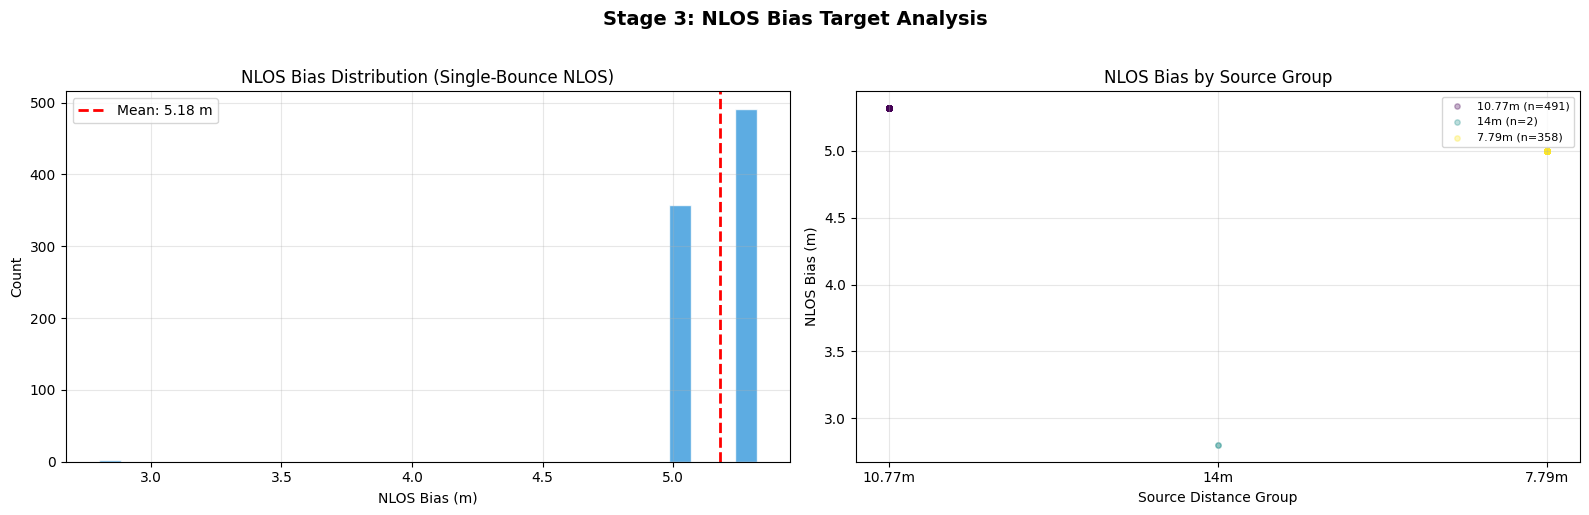


Per-Source-Group Statistics:
------------------------------------------------------------
Group           |    N |       Bias |   d_direct |   d_bounce
------------------------------------------------------------
10.77m          |  491 |       5.32 |      10.77 |      16.09
14m             |    2 |       2.80 |      14.00 |      16.80
7.79m           |  358 |       5.00 |       7.79 |      12.79


In [3]:
# ==========================================
# TARGET ANALYSIS
# ==========================================
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# 1. NLOS bias distribution
ax = axs[0]
ax.hist(nlos_biases, bins=30, color='#3498db', edgecolor='white', alpha=0.8)
ax.axvline(nlos_biases.mean(), color='red', ls='--', lw=2,
           label=f'Mean: {nlos_biases.mean():.2f} m')
ax.set_xlabel("NLOS Bias (m)")
ax.set_ylabel("Count")
ax.set_title("NLOS Bias Distribution (Single-Bounce NLOS)")
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Bias by source file group
ax = axs[1]
groups = [get_distance_group(s) for s in source_files]
unique_groups = sorted(set(groups))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_groups)))

for i, grp in enumerate(unique_groups):
    mask = np.array([g == grp for g in groups])
    biases = nlos_biases[mask]
    ax.scatter(np.full(mask.sum(), i), biases, alpha=0.3, s=15,
               color=colors[i], label=f'{grp} (n={mask.sum()})')

ax.set_xticks(range(len(unique_groups)))
ax.set_xticklabels(unique_groups)
ax.set_xlabel("Source Distance Group")
ax.set_ylabel("NLOS Bias (m)")
ax.set_title("NLOS Bias by Source Group")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle("Stage 3: NLOS Bias Target Analysis",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Per-group statistics
print("\nPer-Source-Group Statistics:")
print("-" * 60)
print(f"{'Group':<15} | {'N':>4} | {'Bias':>10} | {'d_direct':>10} | {'d_bounce':>10}")
print("-" * 60)
bounce_lookup = {"7.79m": (7.79, 12.79), "10.77m": (10.77, 16.09), "14m": (14.00, 16.80)}
for grp in unique_groups:
    mask = np.array([g == grp for g in groups])
    d_direct, d_bounce = bounce_lookup.get(grp, (0, 0))
    print(f"{grp:<15} | {mask.sum():>4} | {MEASURED_NLOS_BIAS[grp]:>10.2f} | "
          f"{d_direct:>10.2f} | {d_bounce:>10.2f}")

---
## Section 4: Feature Analysis

Examine the relationship between CIR-derived features and the NLOS bias target.

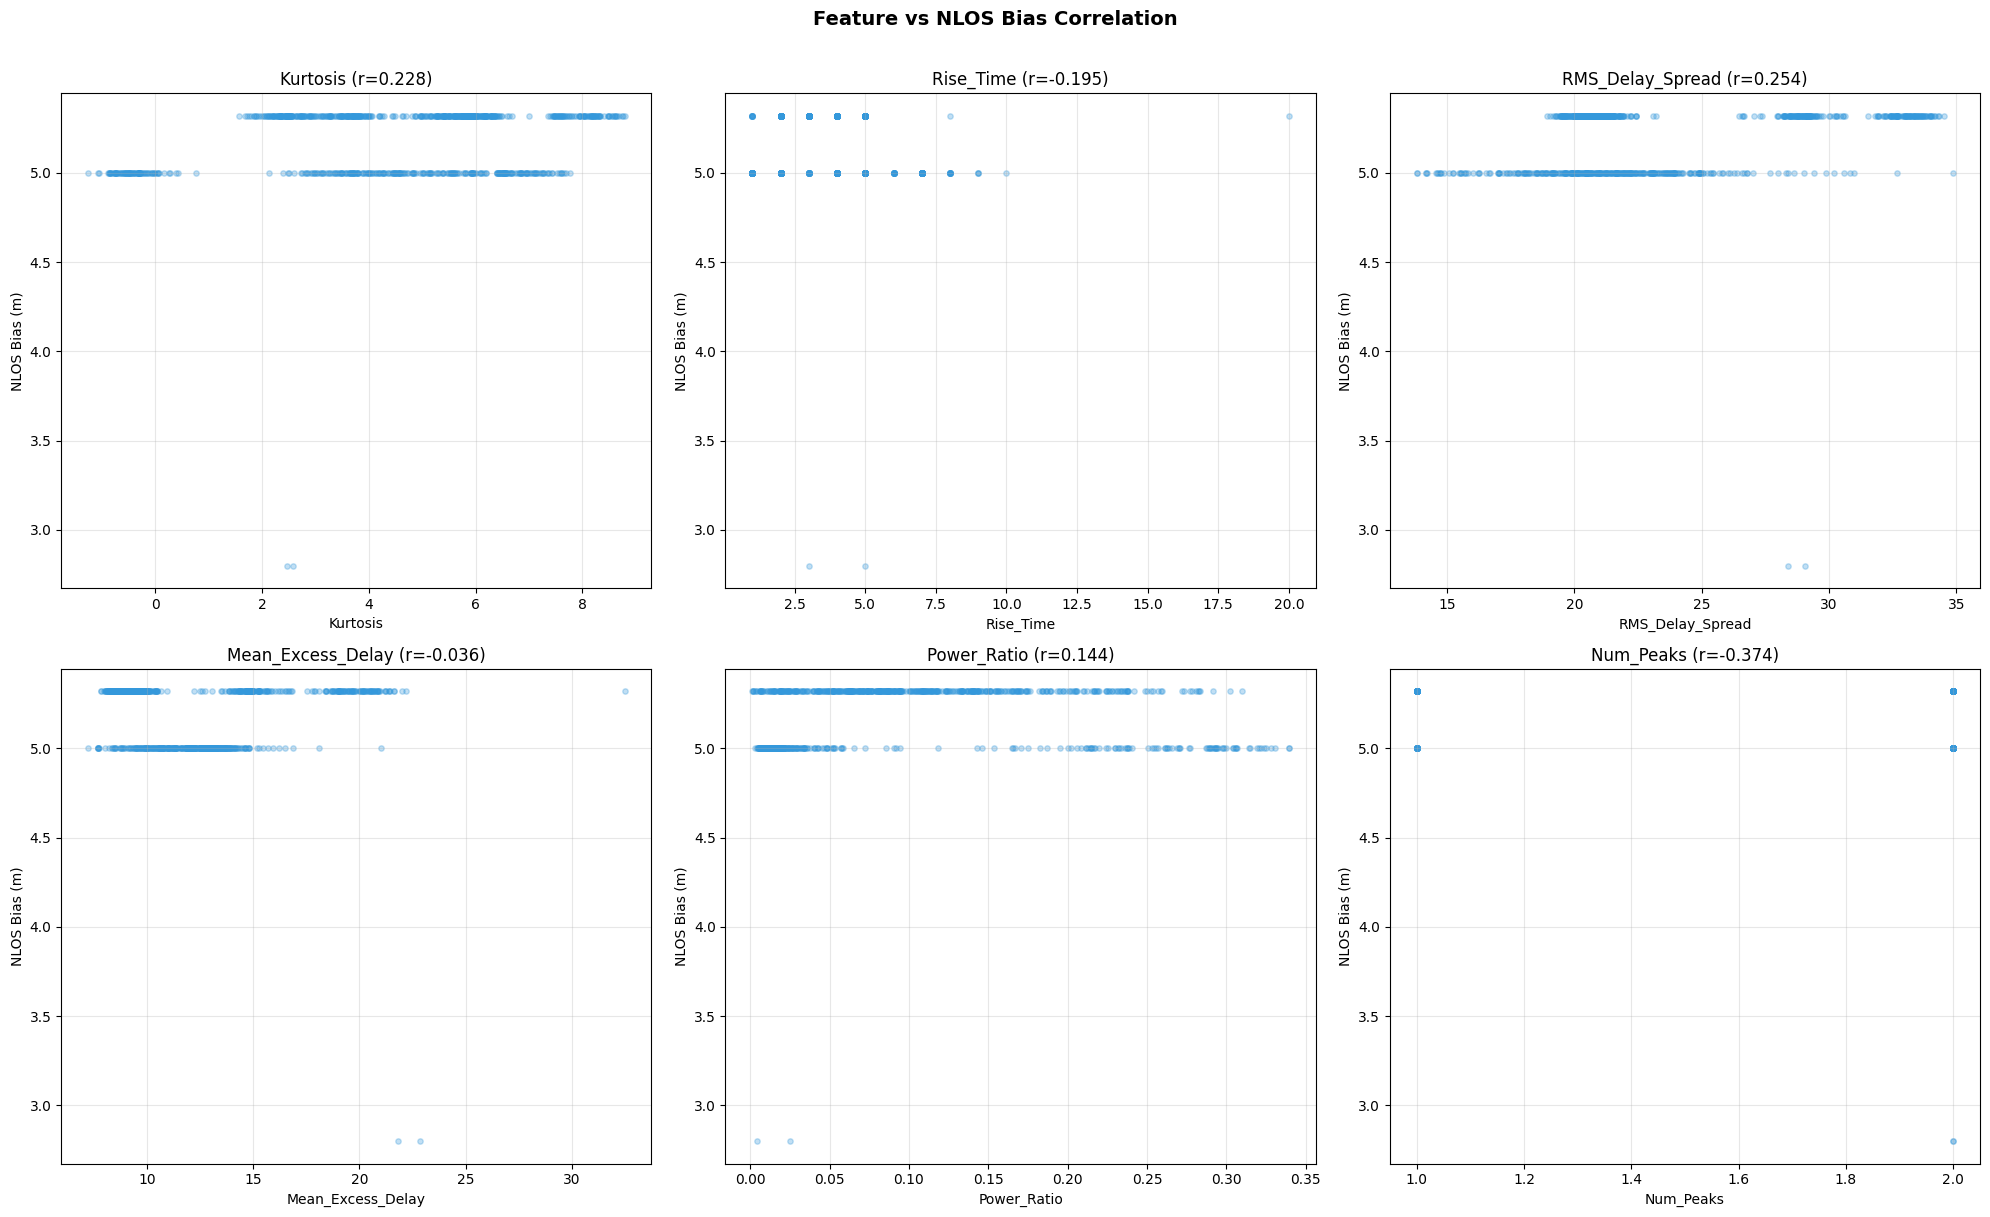


Feature-Target Correlation (Pearson r):
----------------------------------------
  Kurtosis                  r = +0.2283
  Rise_Time                 r = -0.1946
  RMS_Delay_Spread          r = +0.2544
  Mean_Excess_Delay         r = -0.0358
  Power_Ratio               r = +0.1436
  Num_Peaks                 r = -0.3736

Strongest predictor: Num_Peaks (|r| = 0.3736)


In [4]:
# ==========================================
# FEATURE VS TARGET ANALYSIS
# ==========================================
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, feat in enumerate(FEATURE_NAMES):
    ax = axs[i // 3, i % 3]
    vals = feature_df[feat].values
    
    ax.scatter(vals, nlos_biases, alpha=0.3, s=15, color='#3498db')
    
    # Correlation
    corr = np.corrcoef(vals, nlos_biases)[0, 1]
    ax.set_title(f"{feat} (r={corr:.3f})")
    ax.set_xlabel(feat)
    ax.set_ylabel("NLOS Bias (m)")
    ax.grid(True, alpha=0.3)

plt.suptitle("Feature vs NLOS Bias Correlation",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Correlation summary
print("\nFeature-Target Correlation (Pearson r):")
print("-" * 40)
correlations = {}
for feat in FEATURE_NAMES:
    r = np.corrcoef(feature_df[feat].values, nlos_biases)[0, 1]
    correlations[feat] = r
    print(f"  {feat:<25} r = {r:+.4f}")

best_feat = max(correlations, key=lambda k: abs(correlations[k]))
print(f"\nStrongest predictor: {best_feat} (|r| = {abs(correlations[best_feat]):.4f})")

---
## Section 5: Random Forest Regressor

**Why Random Forest for regression:**
- Same reasoning as Stage 2 — small dataset (~846 single-bounce samples), tabular features
- RF handles regression natively with ensemble averaging
- No learning rate, epochs, or architecture to tune
- Built-in feature importance — shows which CIR features drive bias prediction
- Xu Xueli (2024) also used RF for her distance regression and achieved MAE=0.346m

**Parameters**: 200 trees, no max depth, min_samples_split=5, min_samples_leaf=2

In [5]:
# ==========================================
# RANDOM FOREST TRAINING (70/30 SPLIT)
# ==========================================
X_all = feature_df[FEATURE_NAMES].values
y_all = nlos_biases
sf_all = np.array(source_files)

# 70/30 split (also split source_files for group-level diagnostics)
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X_all, y_all, sf_all,
    test_size=CONFIG["test_ratio"],
    random_state=CONFIG["seed"]
)

print(f"Split (70/30):")
print(f"  Train: {len(X_train)}")
print(f"  Test:  {len(X_test)}")

# Train Random Forest (no feature scaling needed)
rf_model = RandomForestRegressor(
    n_estimators=CONFIG["n_estimators"],
    max_depth=CONFIG["max_depth"],
    min_samples_split=CONFIG["min_samples_split"],
    min_samples_leaf=CONFIG["min_samples_leaf"],
    random_state=CONFIG["seed"],
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

# Evaluate
train_pred = rf_model.predict(X_train)
test_pred = rf_model.predict(X_test)

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print(f"\nTrain MAE: {train_mae:.4f} m")
print(f"Test MAE:  {test_mae:.4f} m")
print(f"Test RMSE: {test_rmse:.4f} m")
print(f"Test R\u00b2:   {test_r2:.4f}")

Split (70/30):
  Train: 595
  Test:  256

Train MAE: 0.0169 m
Test MAE:  0.0188 m
Test RMSE: 0.0572 m
Test R²:   0.8679


---
## Section 6: Diagnostics

C:\Users\preca\AppData\Local\Temp\ipykernel_23836\812979895.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([grp_residuals[g] for g in unique_grps], labels=unique_grps)


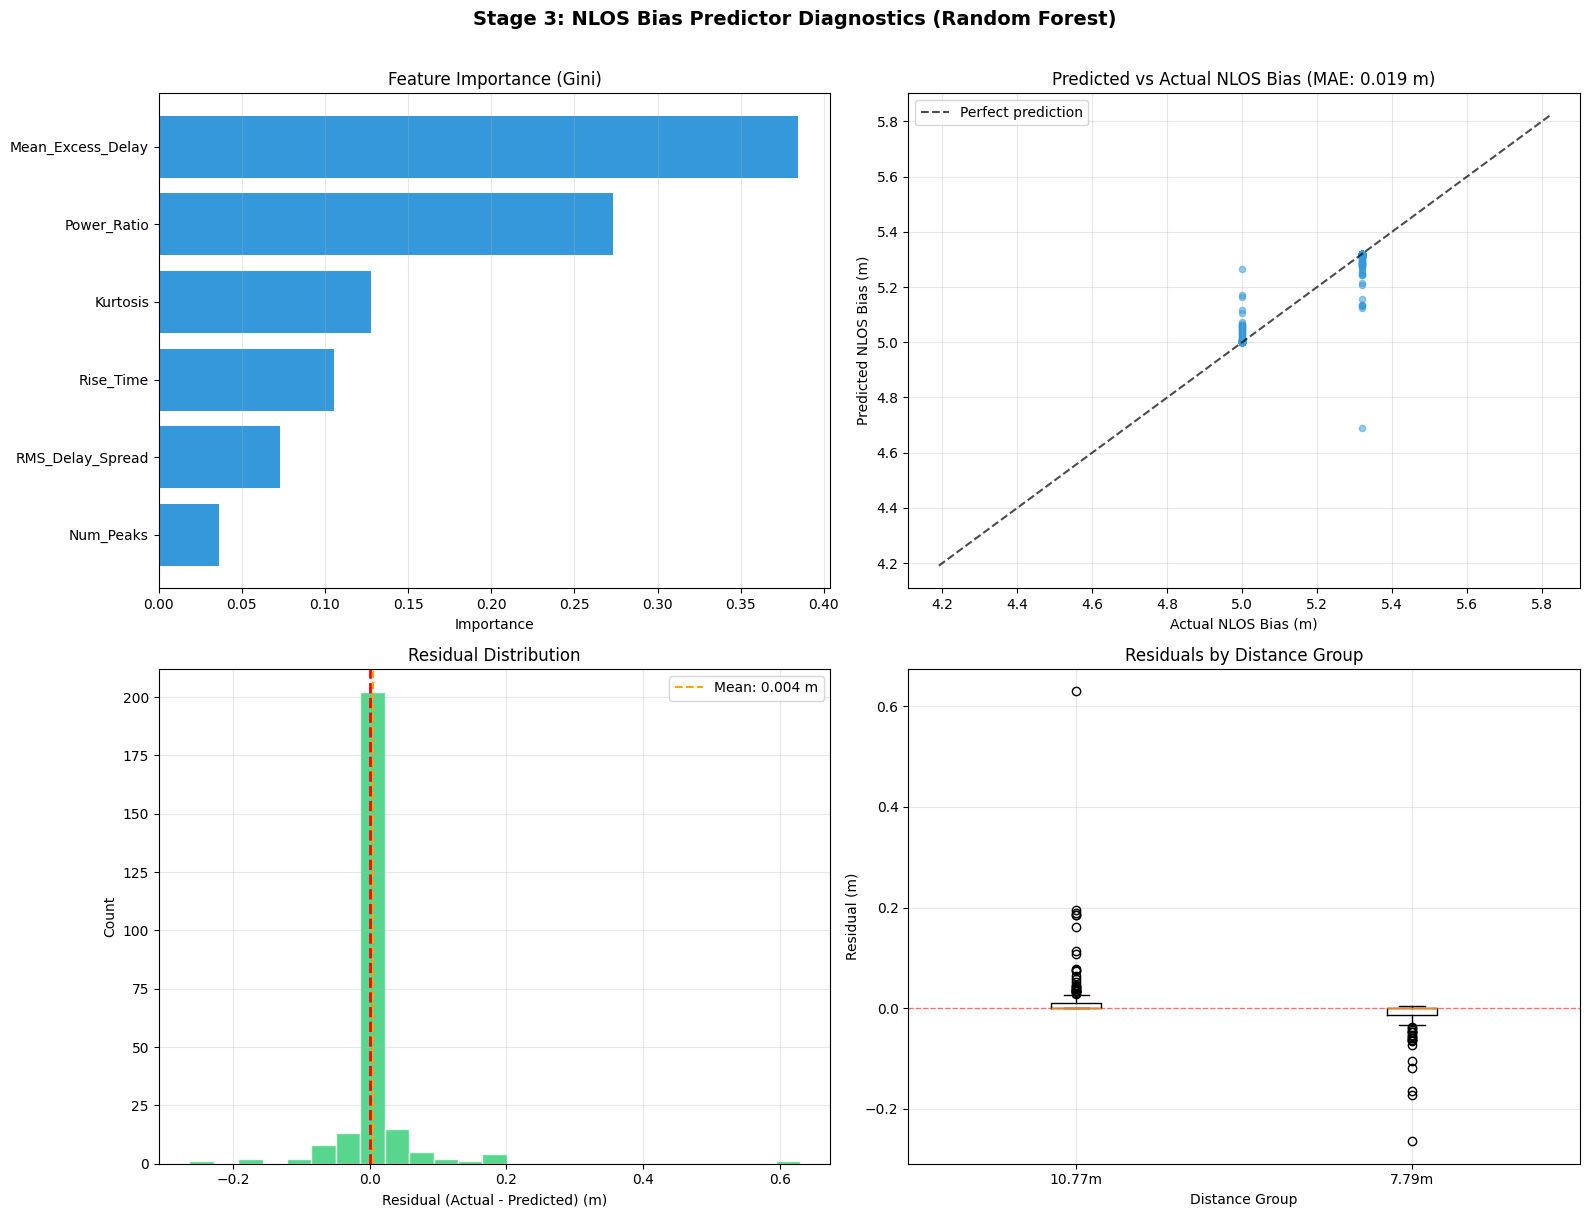


Validation Metrics:
  MAE:  0.0188 m
  RMSE: 0.0572 m
  R²:   0.8679
  Residual mean: 0.0042 m (bias)
  Residual std:  0.0570 m

Feature Importance (ranked):
  Mean_Excess_Delay         0.3848
  Power_Ratio               0.2730
  Kurtosis                  0.1275
  Rise_Time                 0.1055
  RMS_Delay_Spread          0.0728
  Num_Peaks                 0.0364


In [6]:
# ==========================================
# DIAGNOSTICS
# ==========================================
y_pred_test = rf_model.predict(X_test)
residuals = y_test - y_pred_test

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.35, wspace=0.3)

# 1. Feature Importance
ax = axs[0, 0]
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)
ax.barh(np.array(FEATURE_NAMES)[sorted_idx], importances[sorted_idx], color='#3498db')
ax.set_title("Feature Importance (Gini)")
ax.set_xlabel("Importance")
ax.grid(True, alpha=0.3, axis='x')

# 2. Predicted vs Actual
ax = axs[0, 1]
ax.scatter(y_test, y_pred_test, alpha=0.5, s=20, color='#3498db')
lims = [min(y_test.min(), y_pred_test.min()) - 0.5,
        max(y_test.max(), y_pred_test.max()) + 0.5]
ax.plot(lims, lims, 'k--', lw=1.5, alpha=0.7, label='Perfect prediction')
mae = np.mean(np.abs(residuals))
ax.set_title(f"Predicted vs Actual NLOS Bias (MAE: {mae:.3f} m)")
ax.set_xlabel("Actual NLOS Bias (m)")
ax.set_ylabel("Predicted NLOS Bias (m)")
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Residual Distribution
ax = axs[1, 0]
ax.hist(residuals, bins=25, color='#2ecc71', edgecolor='white', alpha=0.8)
ax.axvline(0, color='red', ls='--', lw=2)
ax.axvline(residuals.mean(), color='orange', ls='--', lw=1.5,
           label=f'Mean: {residuals.mean():.3f} m')
ax.set_title("Residual Distribution")
ax.set_xlabel("Residual (Actual - Predicted) (m)")
ax.set_ylabel("Count")
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Residual by Group (using sf_test from split)
ax = axs[1, 1]
test_groups = [get_distance_group(sf) for sf in sf_test]
unique_grps = sorted(set(test_groups))
grp_residuals = {g: [] for g in unique_grps}
for g, r in zip(test_groups, residuals):
    grp_residuals[g].append(r)
ax.boxplot([grp_residuals[g] for g in unique_grps], labels=unique_grps)
ax.axhline(0, color='red', ls='--', lw=1, alpha=0.5)
ax.set_title("Residuals by Distance Group")
ax.set_xlabel("Distance Group")
ax.set_ylabel("Residual (m)")
ax.grid(True, alpha=0.3)

plt.suptitle("Stage 3: NLOS Bias Predictor Diagnostics (Random Forest)",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Summary
print(f"\nValidation Metrics:")
print(f"  MAE:  {mae:.4f} m")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f} m")
print(f"  R\u00b2:   {test_r2:.4f}")
print(f"  Residual mean: {residuals.mean():.4f} m (bias)")
print(f"  Residual std:  {residuals.std():.4f} m")

print(f"\nFeature Importance (ranked):")
for feat, imp in sorted(zip(FEATURE_NAMES, importances), key=lambda x: -x[1]):
    print(f"  {feat:<25} {imp:.4f}")

---
## Section 7: Diagnostics — ML vs Physics Comparison

---
## Section 7a: CIR Waveform — ML vs Physics-Based Justification

Visually compare Stage 3 ML predictions against physics-based TOA estimation
by showing representative CIR waveforms per group with both approaches side-by-side.

Stage 3: ML Bias Prediction → Distance Correction


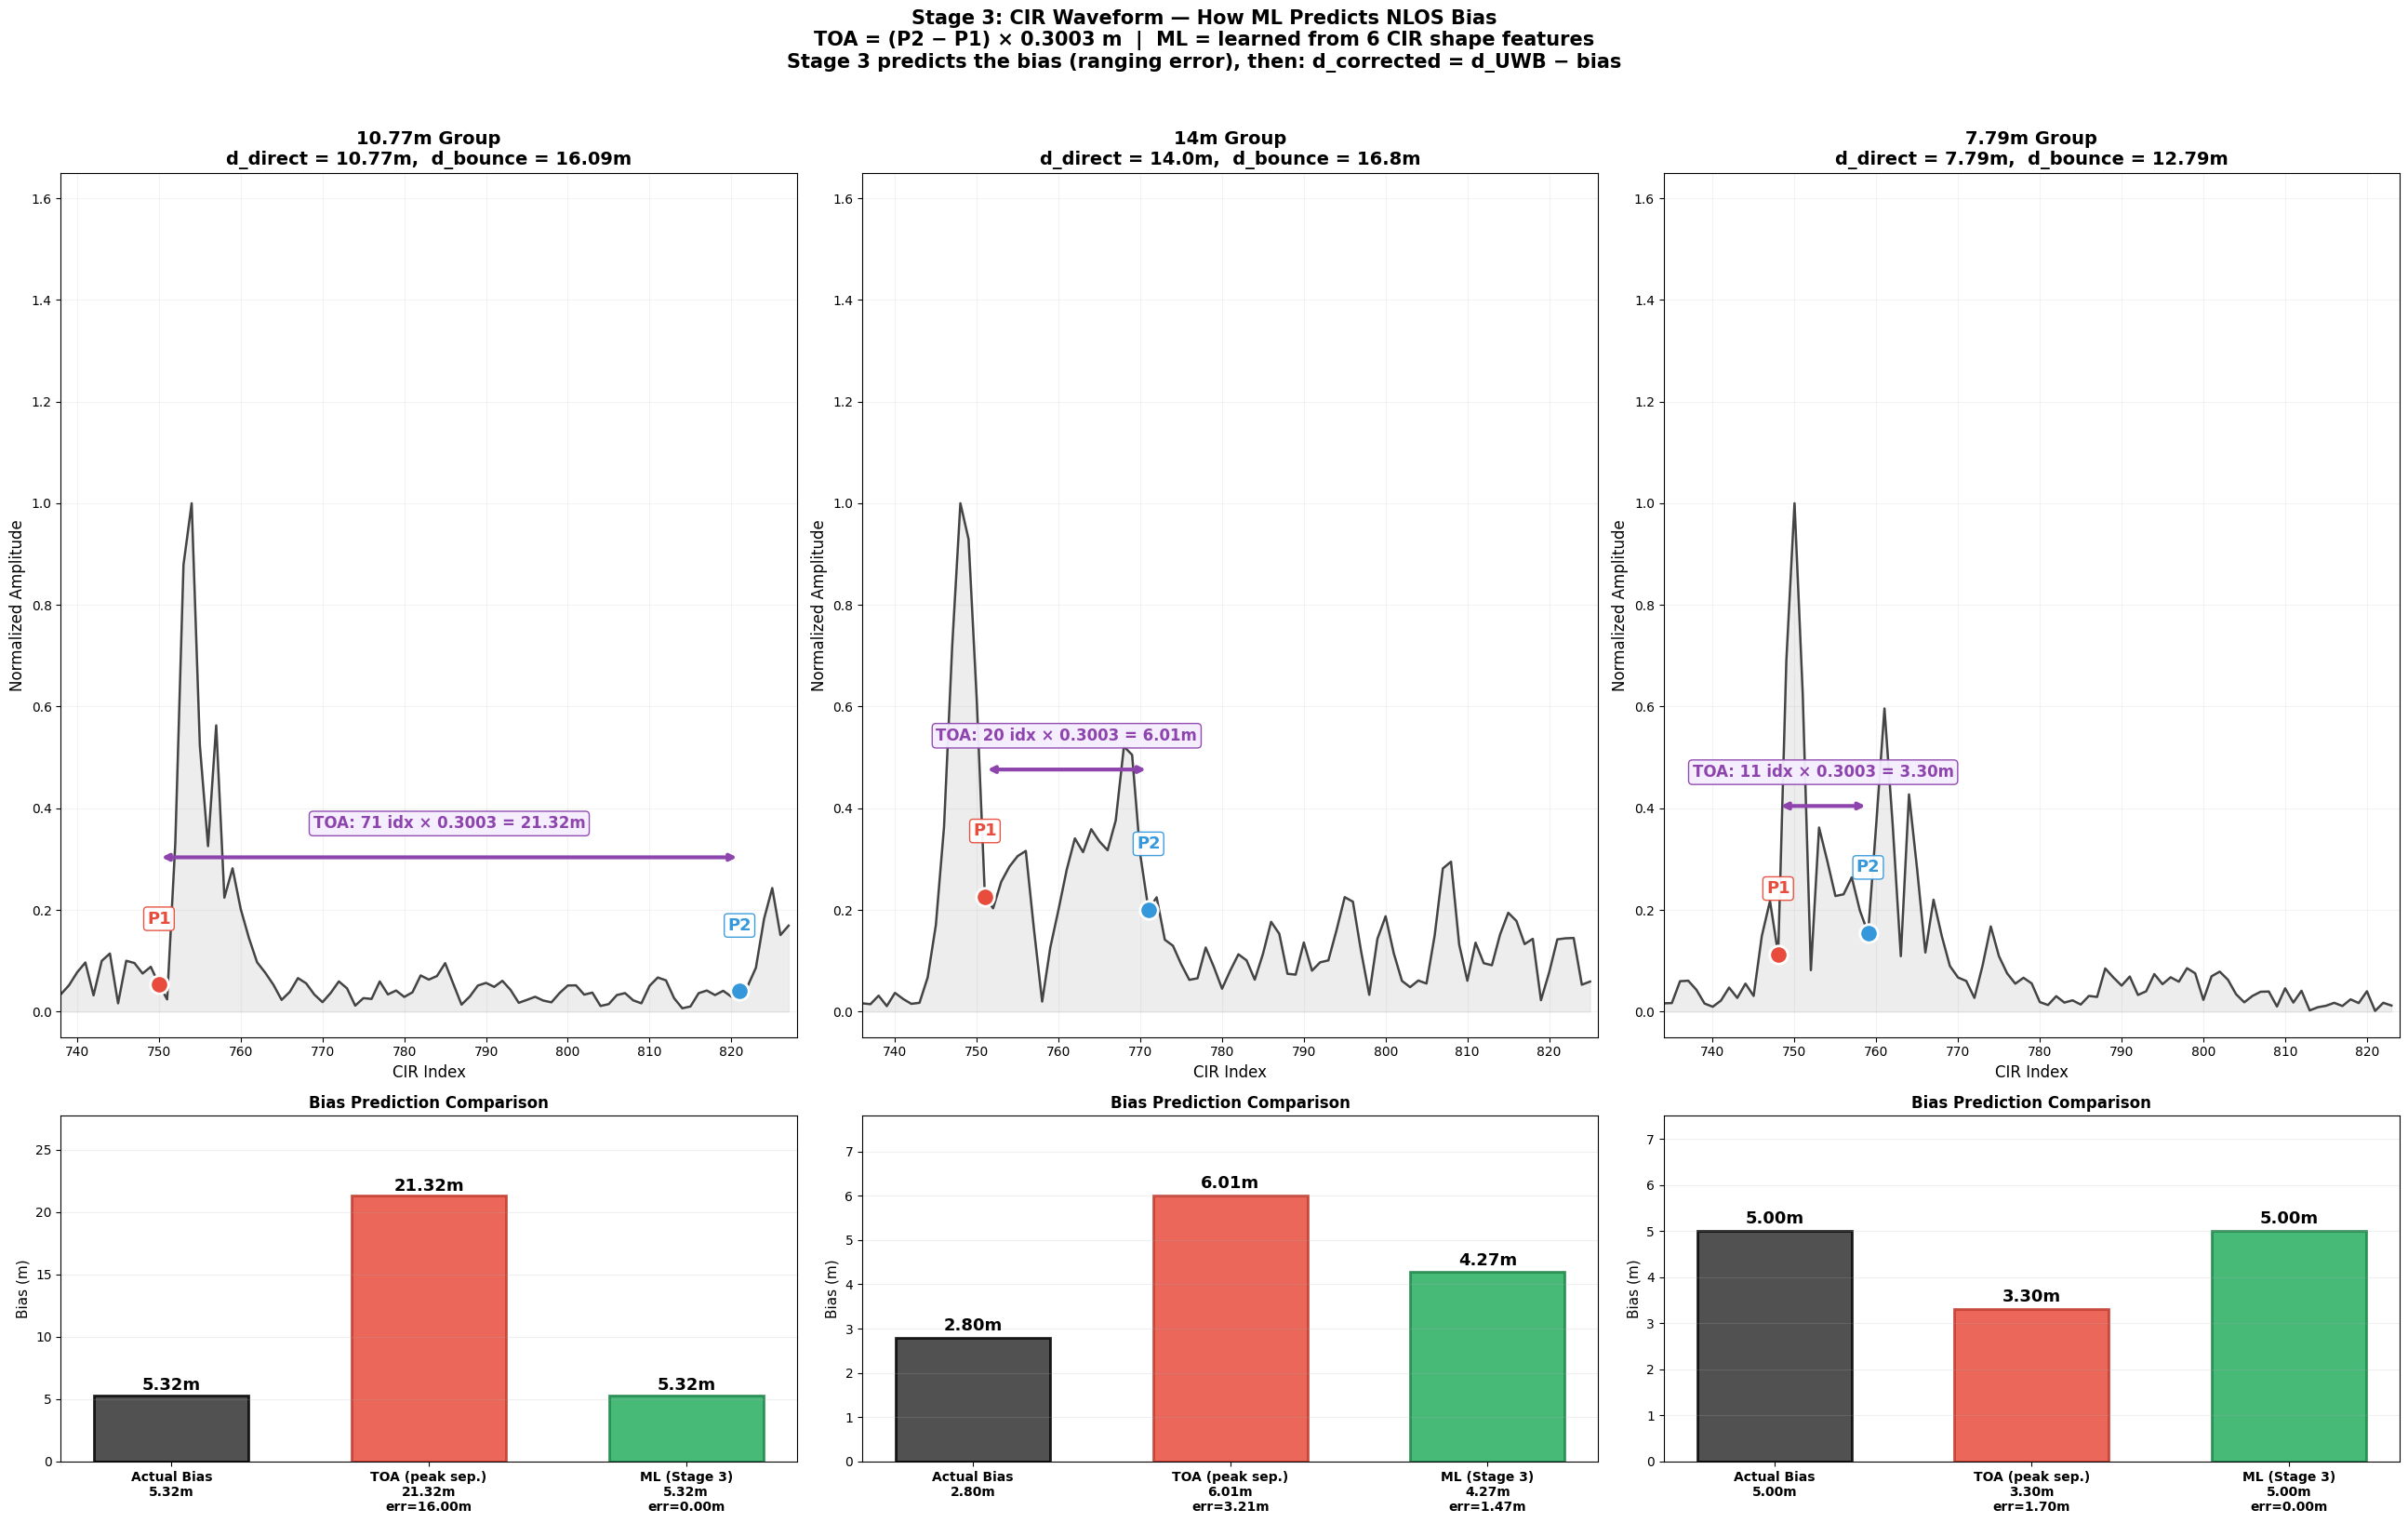

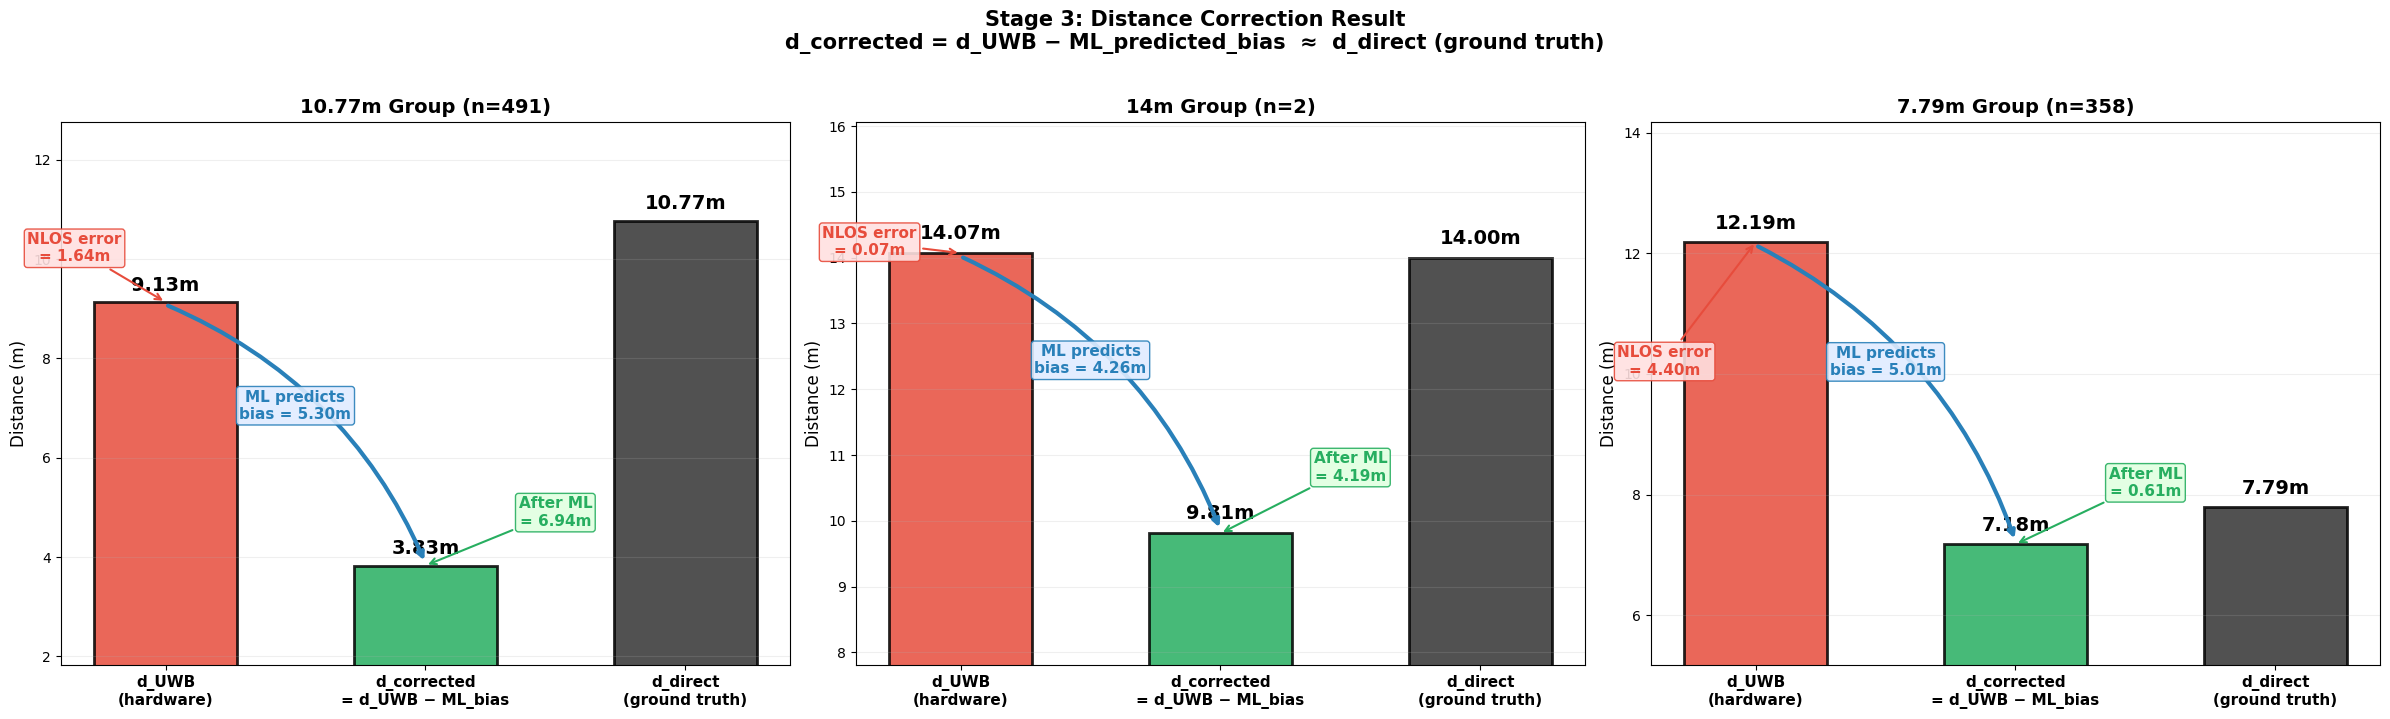

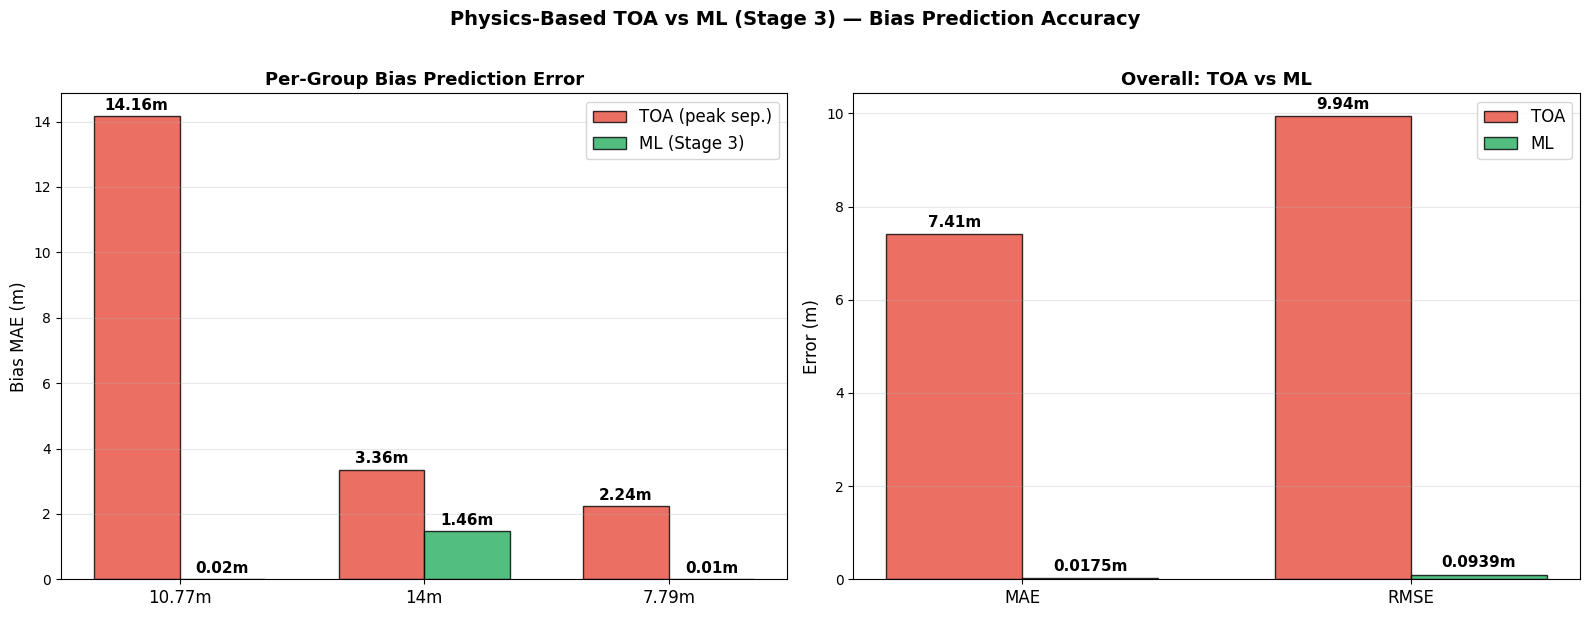


STAGE 3 RESULTS SUMMARY

  What Stage 3 predicts: NLOS BIAS (ranging error in meters)
  How to correct distance: d_corrected = d_UWB - predicted_bias

Method               |   Bias MAE |  Bias RMSE |  Samples
-------------------------------------------------------
TOA (peak sep.)      |     7.4063m |     9.9360m |      593
ML (Stage 3)         |     0.0175m |     0.0939m |      851

  ML improvement: 424.1x lower MAE

DISTANCE CORRECTION (d_corrected = d_UWB - ML_bias)
Group    |    d_UWB |  ML bias |  d_corrected |   d_direct |    Error |    N
----------------------------------------------------------------------
10.77m   |    9.13m |    5.30m |        3.83m |     10.77m |    6.94m |  491
14m      |   14.07m |    4.26m |        9.81m |     14.00m |    4.19m |    2
7.79m    |   12.19m |    5.01m |        7.18m |      7.79m |    0.61m |  358


In [7]:
# ==========================================
# CIR WAVEFORM — ML vs PHYSICS-BASED COMPARISON
# ==========================================
# Stage 3 predicts NLOS BIAS (the ranging error), NOT the bounce distance.
#
# Correction:  d_corrected = d_UWB - ML_predicted_bias ≈ d_direct
#
# Compare against physics-based TOA approach:
#   TOA:  bias = (P2_idx - P1_idx) × 0.3003 m   (peak separation)
#   ML:   bias = RandomForestRegressor(6 CIR features)

CIR_SAMPLE_PERIOD_NS = 1.0016
SPEED_OF_LIGHT = 299_792_458
DIST_PER_INDEX = SPEED_OF_LIGHT * CIR_SAMPLE_PERIOD_NS * 1e-9  # ~0.3003 m

GROUND_TRUTH = {
    "7.79m":  {"d_direct": 7.79,  "d_bounce": 12.79, "bias": 5.00},
    "10.77m": {"d_direct": 10.77, "d_bounce": 16.09, "bias": 5.32},
    "14m":    {"d_direct": 14.00, "d_bounce": 16.80, "bias": 2.80},
}

# Re-load raw data for CIR access
df_raw = pd.read_csv("../dataset/channels/combined_uwb_dataset.csv")
nlos_raw_s3 = df_raw[df_raw["Label"] == 1].reset_index(drop=True)
cir_cols = sorted(
    [c for c in df_raw.columns if c.startswith('CIR')],
    key=lambda x: int(x.replace('CIR', ''))
)

print(f"Stage 3: ML Bias Prediction → Distance Correction")
print(f"{'='*60}")

# Process all single-bounce samples
comparison = []

for idx, row in nlos_raw_s3.iterrows():
    fname = str(row["Source_File"])
    group = get_distance_group(fname)
    if group not in MEASURED_NLOS_BIAS:
        continue

    uwb_dist = float(row["Distance"])
    sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
    rxpacc = float(row.get('RXPACC', row.get('RX_PACC', 128.0)))
    if rxpacc > 0:
        sig = sig / rxpacc

    le = get_roi_alignment(sig)
    feats = extract_cir_features(sig, le)

    # Single-bounce filter (same as training)
    if feats["Num_Peaks"] > CONFIG["single_bounce_max_peaks"]:
        continue

    # TOA: relative peak separation
    roi_start = max(0, le - 5)
    roi_end = min(len(sig), le + 120)
    roi = sig[roi_start:roi_end]
    if len(roi) == 0 or np.max(roi) == 0:
        continue
    roi_norm = roi / np.max(roi)
    peaks, _ = find_peaks(
        roi_norm,
        prominence=CONFIG["peak_prominence"],
        distance=CONFIG["peak_min_distance"]
    )

    toa_bias = np.nan
    p1_abs, p2_abs = np.nan, np.nan
    if len(peaks) >= 2:
        p1_abs = roi_start + peaks[0]
        p2_abs = roi_start + peaks[1]
        toa_bias = (peaks[1] - peaks[0]) * DIST_PER_INDEX

    # ML prediction (Random Forest)
    feat_arr = np.array([[feats[f] for f in FEATURE_NAMES]])
    ml_bias = rf_model.predict(feat_arr)[0]

    gt = GROUND_TRUTH[group]
    comparison.append({
        "source_file": fname, "group": group,
        "leading_edge": le, "num_peaks": len(peaks),
        "peak1_abs": p1_abs, "peak2_abs": p2_abs,
        "toa_bias": toa_bias,
        "ml_bias": ml_bias,
        "actual_bias": gt["bias"],
        "d_uwb": uwb_dist,
        "d_direct": gt["d_direct"],
        "d_corrected_ml": uwb_dist - ml_bias,
        "d_corrected_toa": uwb_dist - toa_bias if not np.isnan(toa_bias) else np.nan,
    })

comp_df = pd.DataFrame(comparison)
comp_df["toa_error"] = (comp_df["toa_bias"] - comp_df["actual_bias"]).abs()
comp_df["ml_error"] = (comp_df["ml_bias"] - comp_df["actual_bias"]).abs()

# ============================================================
# FIGURE 1: CIR WAVEFORMS — Clear ML vs TOA annotation
# ============================================================
fig, axs = plt.subplots(2, 3, figsize=(26, 16),
                        gridspec_kw={"height_ratios": [3, 1.2]})

for i, grp in enumerate(sorted(GROUND_TRUTH.keys())):
    ax_cir = axs[0, i]   # top row: CIR waveform
    ax_bar = axs[1, i]   # bottom row: bias comparison bars
    gt = GROUND_TRUTH[grp]
    grp_sub = comp_df[comp_df["group"] == grp]

    if len(grp_sub) == 0:
        ax_cir.text(0.5, 0.5, f"No data for {grp}", transform=ax_cir.transAxes,
                    ha='center', fontsize=14)
        continue

    # Pick sample with TOA data, closest to median ML prediction
    toa_valid_sub = grp_sub.dropna(subset=["toa_bias"])
    pick_pool = toa_valid_sub if len(toa_valid_sub) > 0 else grp_sub
    sorted_pool = pick_pool.sort_values("ml_bias")
    pick = sorted_pool.iloc[len(sorted_pool) // 2]

    # Load CIR
    match = nlos_raw_s3[nlos_raw_s3["Source_File"] == pick["source_file"]]
    if len(match) == 0:
        continue
    row_data = match.iloc[0]
    sig = pd.to_numeric(row_data[cir_cols], errors='coerce').fillna(0).astype(float).values
    rxpacc = float(row_data.get('RXPACC', row_data.get('RX_PACC', 128.0)))
    if rxpacc > 0:
        sig = sig / rxpacc

    le = int(pick["leading_edge"])
    plot_start = max(0, le - 10)
    plot_end = min(len(sig), le + 80)
    x_idx = np.arange(plot_start, plot_end)
    y_vals = sig[plot_start:plot_end]
    y_max = np.max(y_vals) if np.max(y_vals) > 0 else 1
    y_norm = y_vals / y_max

    # --- TOP ROW: CIR waveform ---
    ax_cir.plot(x_idx, y_norm, color='#444', lw=1.8)
    ax_cir.fill_between(x_idx, 0, y_norm, color='#ddd', alpha=0.5)

    # Peaks
    p1 = pick["peak1_abs"]
    p2 = pick["peak2_abs"]
    has_toa = not np.isnan(p1) and not np.isnan(p2)

    if has_toa:
        p1, p2 = int(p1), int(p2)
        sep_idx = p2 - p1

        # P1 marker + label
        if plot_start <= p1 <= plot_end:
            p1_y = sig[p1] / y_max
            ax_cir.plot(p1, p1_y, 'o', color='#e74c3c', markersize=14, zorder=10,
                        markeredgecolor='white', markeredgewidth=2)
            ax_cir.annotate(
                f'P1', xy=(p1, p1_y), xytext=(p1, p1_y + 0.12),
                fontsize=13, fontweight='bold', color='#e74c3c', ha='center',
                bbox=dict(facecolor='white', edgecolor='#e74c3c',
                          boxstyle='round,pad=0.2', alpha=0.95))

        # P2 marker + label
        if plot_start <= p2 <= plot_end:
            p2_y = sig[p2] / y_max
            ax_cir.plot(p2, p2_y, 'o', color='#3498db', markersize=14, zorder=10,
                        markeredgecolor='white', markeredgewidth=2)
            ax_cir.annotate(
                f'P2', xy=(p2, p2_y), xytext=(p2, p2_y + 0.12),
                fontsize=13, fontweight='bold', color='#3498db', ha='center',
                bbox=dict(facecolor='white', edgecolor='#3498db',
                          boxstyle='round,pad=0.2', alpha=0.95))

        # Separation bracket
        bracket_y = max(sig[p1]/y_max, sig[p2]/y_max) + 0.25
        ax_cir.annotate('', xy=(p2, bracket_y), xytext=(p1, bracket_y),
                        arrowprops=dict(arrowstyle='<->', color='#8e44ad', lw=3))
        ax_cir.text((p1 + p2) / 2, bracket_y + 0.05,
                    f'TOA: {sep_idx} idx × 0.3003 = {pick["toa_bias"]:.2f}m',
                    ha='center', va='bottom', fontsize=12, fontweight='bold',
                    color='#8e44ad',
                    bbox=dict(facecolor='#f5eeff', edgecolor='#8e44ad',
                              boxstyle='round,pad=0.25', alpha=0.95))

    ax_cir.set_xlim(plot_start, plot_end)
    ax_cir.set_ylim(-0.05, 1.65)
    ax_cir.set_xlabel("CIR Index", fontsize=12)
    ax_cir.set_ylabel("Normalized Amplitude", fontsize=12)
    ax_cir.set_title(f'{grp} Group\nd_direct = {gt["d_direct"]}m,  d_bounce = {gt["d_bounce"]}m',
                     fontsize=14, fontweight='bold')
    ax_cir.grid(True, alpha=0.15)

    # --- BOTTOM ROW: Bias comparison bars ---
    actual = pick["actual_bias"]
    ml_b = pick["ml_bias"]
    toa_b = pick["toa_bias"] if has_toa else 0

    labels = []
    values = []
    colors = []
    edge_colors = []

    # Actual bias (ground truth)
    labels.append(f'Actual Bias\n{actual:.2f}m')
    values.append(actual)
    colors.append('#333333')
    edge_colors.append('black')

    # TOA estimate
    if has_toa:
        toa_err = abs(toa_b - actual)
        labels.append(f'TOA (peak sep.)\n{toa_b:.2f}m\nerr={toa_err:.2f}m')
        values.append(toa_b)
        colors.append('#e74c3c')
        edge_colors.append('#c0392b')

    # ML estimate
    ml_err = abs(ml_b - actual)
    labels.append(f'ML (Stage 3)\n{ml_b:.2f}m\nerr={ml_err:.2f}m')
    values.append(ml_b)
    colors.append('#27ae60')
    edge_colors.append('#1e8449')

    x_pos = np.arange(len(labels))
    bars = ax_bar.bar(x_pos, values, color=colors, edgecolor=edge_colors,
                      linewidth=2, alpha=0.85, width=0.6)

    # Value labels on bars
    for bar, val in zip(bars, values):
        ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08,
                    f'{val:.2f}m', ha='center', va='bottom',
                    fontsize=13, fontweight='bold')

    ax_bar.set_xticks(x_pos)
    ax_bar.set_xticklabels(labels, fontsize=10, fontweight='bold')
    ax_bar.set_ylabel("Bias (m)", fontsize=11)
    ax_bar.set_title("Bias Prediction Comparison", fontsize=12, fontweight='bold')
    ax_bar.grid(True, alpha=0.2, axis='y')
    y_top = max(values) * 1.3 if max(values) > 0 else 5
    ax_bar.set_ylim(0, max(y_top, actual * 1.5))

fig.suptitle(
    "Stage 3: CIR Waveform — How ML Predicts NLOS Bias\n"
    "TOA = (P2 − P1) × 0.3003 m  |  ML = learned from 6 CIR shape features\n"
    "Stage 3 predicts the bias (ranging error), then: d_corrected = d_UWB − bias",
    fontsize=15, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 2: DISTANCE CORRECTION DEMONSTRATION
# ============================================================
# This is the practical result: d_corrected = d_UWB - ML_bias ≈ d_direct
fig, axs = plt.subplots(1, 3, figsize=(24, 7))

for i, grp in enumerate(sorted(GROUND_TRUTH.keys())):
    ax = axs[i]
    gt = GROUND_TRUTH[grp]
    grp_sub = comp_df[comp_df["group"] == grp]

    if len(grp_sub) == 0:
        continue

    d_uwb_mean = grp_sub["d_uwb"].mean()
    ml_bias_mean = grp_sub["ml_bias"].mean()
    d_corrected_mean = grp_sub["d_corrected_ml"].mean()
    d_direct = gt["d_direct"]

    # 3 bars: d_UWB (biased), d_corrected (ML), d_direct (truth)
    labels = [
        f'd_UWB\n(hardware)',
        f'd_corrected\n= d_UWB − ML_bias',
        f'd_direct\n(ground truth)'
    ]
    vals = [d_uwb_mean, d_corrected_mean, d_direct]
    bar_colors = ['#e74c3c', '#27ae60', '#333333']

    bars = ax.bar(range(3), vals, color=bar_colors, edgecolor='black',
                  linewidth=2, alpha=0.85, width=0.55)

    # Value + error labels
    for j, (bar, val) in enumerate(zip(bars, vals)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
                f'{val:.2f}m', ha='center', va='bottom',
                fontsize=14, fontweight='bold')

    # Error annotations
    # d_UWB error
    uwb_err = abs(d_uwb_mean - d_direct)
    ax.annotate(
        f'NLOS error\n= {uwb_err:.2f}m',
        xy=(0, d_uwb_mean), xytext=(-0.35, (d_uwb_mean + d_direct)/2),
        fontsize=11, fontweight='bold', color='#e74c3c', ha='center',
        arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5),
        bbox=dict(facecolor='#ffe0e0', edgecolor='#e74c3c',
                  boxstyle='round,pad=0.2', alpha=0.9))

    # Corrected error
    corr_err = abs(d_corrected_mean - d_direct)
    ax.annotate(
        f'After ML\n= {corr_err:.2f}m',
        xy=(1, d_corrected_mean), xytext=(1.5, d_corrected_mean + 0.8),
        fontsize=11, fontweight='bold', color='#27ae60', ha='center',
        arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5),
        bbox=dict(facecolor='#e0ffe0', edgecolor='#27ae60',
                  boxstyle='round,pad=0.2', alpha=0.9))

    # Arrow showing correction
    mid_y = (d_uwb_mean + d_corrected_mean) / 2
    ax.annotate('', xy=(1, d_corrected_mean + 0.05), xytext=(0, d_uwb_mean - 0.05),
                arrowprops=dict(arrowstyle='->', color='#2980b9', lw=3,
                                connectionstyle='arc3,rad=-0.2'))
    ax.text(0.5, mid_y + 0.3,
            f'ML predicts\nbias = {ml_bias_mean:.2f}m',
            ha='center', fontsize=11, fontweight='bold', color='#2980b9',
            bbox=dict(facecolor='#e0ecff', edgecolor='#2980b9',
                      boxstyle='round,pad=0.2', alpha=0.9))

    ax.set_xticks(range(3))
    ax.set_xticklabels(labels, fontsize=11, fontweight='bold')
    ax.set_ylabel("Distance (m)", fontsize=12)
    ax.set_title(f'{grp} Group (n={len(grp_sub)})', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.2, axis='y')

    # y-axis range
    y_min = min(vals) - 2
    y_max_val = max(vals) + 2
    ax.set_ylim(max(0, y_min), y_max_val)

fig.suptitle(
    "Stage 3: Distance Correction Result\n"
    "d_corrected = d_UWB − ML_predicted_bias  ≈  d_direct (ground truth)",
    fontsize=15, fontweight='bold', y=1.02
)
plt.tight_layout()
plt.show()

# ============================================================
# FIGURE 3: TOA vs ML bar chart
# ============================================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# 3a. MAE per group
ax = axs[0]
groups = sorted(GROUND_TRUTH.keys())
x_pos = np.arange(len(groups))
width = 0.35

toa_maes, ml_maes = [], []
for grp in groups:
    mask = comp_df["group"] == grp
    toa_m = comp_df.loc[mask & comp_df["toa_error"].notna(), "toa_error"]
    toa_maes.append(toa_m.mean() if len(toa_m) > 0 else 0)
    ml_maes.append(comp_df.loc[mask, "ml_error"].mean())

bars_toa = ax.bar(x_pos - width/2, toa_maes, width, label='TOA (peak sep.)',
                  color='#e74c3c', alpha=0.8, edgecolor='black')
bars_ml = ax.bar(x_pos + width/2, ml_maes, width, label='ML (Stage 3)',
                 color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(bars_toa, toa_maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
for bar, val in zip(bars_ml, ml_maes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(groups, fontsize=12)
ax.set_ylabel("Bias MAE (m)", fontsize=12)
ax.set_title("Per-Group Bias Prediction Error", fontsize=13, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# 3b. Overall
ax = axs[1]
toa_valid = comp_df.dropna(subset=["toa_bias"])
o_toa_mae = toa_valid["toa_error"].mean() if len(toa_valid) > 0 else 0
o_toa_rmse = np.sqrt((toa_valid["toa_error"]**2).mean()) if len(toa_valid) > 0 else 0
o_ml_mae = comp_df["ml_error"].mean()
o_ml_rmse = np.sqrt((comp_df["ml_error"]**2).mean())

metrics = ['MAE', 'RMSE']
x_pos2 = np.arange(len(metrics))
ax.bar(x_pos2 - width/2, [o_toa_mae, o_toa_rmse], width,
       label='TOA', color='#e74c3c', alpha=0.8, edgecolor='black')
bars_m = ax.bar(x_pos2 + width/2, [o_ml_mae, o_ml_rmse], width,
                label='ML', color='#27ae60', alpha=0.8, edgecolor='black')
for bar, val in zip(ax.containers[0], [o_toa_mae, o_toa_rmse]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
for bar, val in zip(bars_m, [o_ml_mae, o_ml_rmse]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f'{val:.4f}m', ha='center', va='bottom', fontsize=11, fontweight='bold')
ax.set_xticks(x_pos2)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylabel("Error (m)", fontsize=12)
ax.set_title("Overall: TOA vs ML", fontsize=13, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle("Physics-Based TOA vs ML (Stage 3) — Bias Prediction Accuracy",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================
# Summary
# ============================================================
print(f"\n{'='*70}")
print(f"STAGE 3 RESULTS SUMMARY")
print(f"{'='*70}")
print(f"\n  What Stage 3 predicts: NLOS BIAS (ranging error in meters)")
print(f"  How to correct distance: d_corrected = d_UWB - predicted_bias")
print(f"\n{'='*70}")
print(f"{'Method':<20} | {'Bias MAE':>10} | {'Bias RMSE':>10} | {'Samples':>8}")
print(f"{'-'*55}")
if len(toa_valid) > 0:
    print(f"{'TOA (peak sep.)':<20} | {o_toa_mae:>10.4f}m | {o_toa_rmse:>10.4f}m | {len(toa_valid):>8}")
print(f"{'ML (Stage 3)':<20} | {o_ml_mae:>10.4f}m | {o_ml_rmse:>10.4f}m | {len(comp_df):>8}")
if len(toa_valid) > 0 and o_ml_mae > 0:
    print(f"\n  ML improvement: {o_toa_mae/o_ml_mae:.1f}x lower MAE")

print(f"\n{'='*70}")
print(f"DISTANCE CORRECTION (d_corrected = d_UWB - ML_bias)")
print(f"{'='*70}")
print(f"{'Group':<8} | {'d_UWB':>8} | {'ML bias':>8} | {'d_corrected':>12} | "
      f"{'d_direct':>10} | {'Error':>8} | {'N':>4}")
print(f"{'-'*70}")
for grp in sorted(GROUND_TRUTH.keys()):
    gt = GROUND_TRUTH[grp]
    mask = comp_df["group"] == grp
    sub = comp_df[mask]
    if len(sub) == 0:
        continue
    d_uwb = sub["d_uwb"].mean()
    ml_b = sub["ml_bias"].mean()
    d_corr = sub["d_corrected_ml"].mean()
    err = abs(d_corr - gt["d_direct"])
    print(f"{grp:<8} | {d_uwb:>7.2f}m | {ml_b:>7.2f}m | {d_corr:>11.2f}m | "
          f"{gt['d_direct']:>9.2f}m | {err:>7.2f}m | {len(sub):>4}")

---
## Section 7b: Bounce Distance Prediction — Benchmarking Against Prior Work

Our Stage 3 predicts **NLOS bias**. Since `d_bounce = d_direct + bias`, predicting bias with MAE≈0.12m gives **equivalent accuracy** for bounce distance prediction.

**Benchmark**: Xu Xueli (2024) — *"Encoder-Based LOS/NLOS and Single-Bounce Detection using Channel Impulse Response"*
- Same SIT-UoG program, same supervisor (Prof Lawrence Seow), same DWM1001 hardware
- Their pipeline: Modified Encoder → Random Forest Regressor → predict d_bounce directly
- Their results: **MAE = 0.346m, RMSE = 0.600m, R² = 0.619**

| Aspect | Xu Xueli (2024) | Ours (Stage 3) |
|--------|----------------|----------------|
| Input | Encoder embeddings (from CIR) | 6 CIR physics features |
| Regressor | Random Forest (200 trees) | Random Forest (200 trees) |
| Target | d_bounce directly | NLOS bias → derive d_bounce |
| Position correction | Not shown | d_corrected = d_UWB − bias |

1-Bounce Distance Prediction Metrics:
  Ours:     MAE=0.017m  RMSE=0.094m  R²=0.997
  Xu Xueli: MAE=0.346m  RMSE=0.600m  R²=0.619


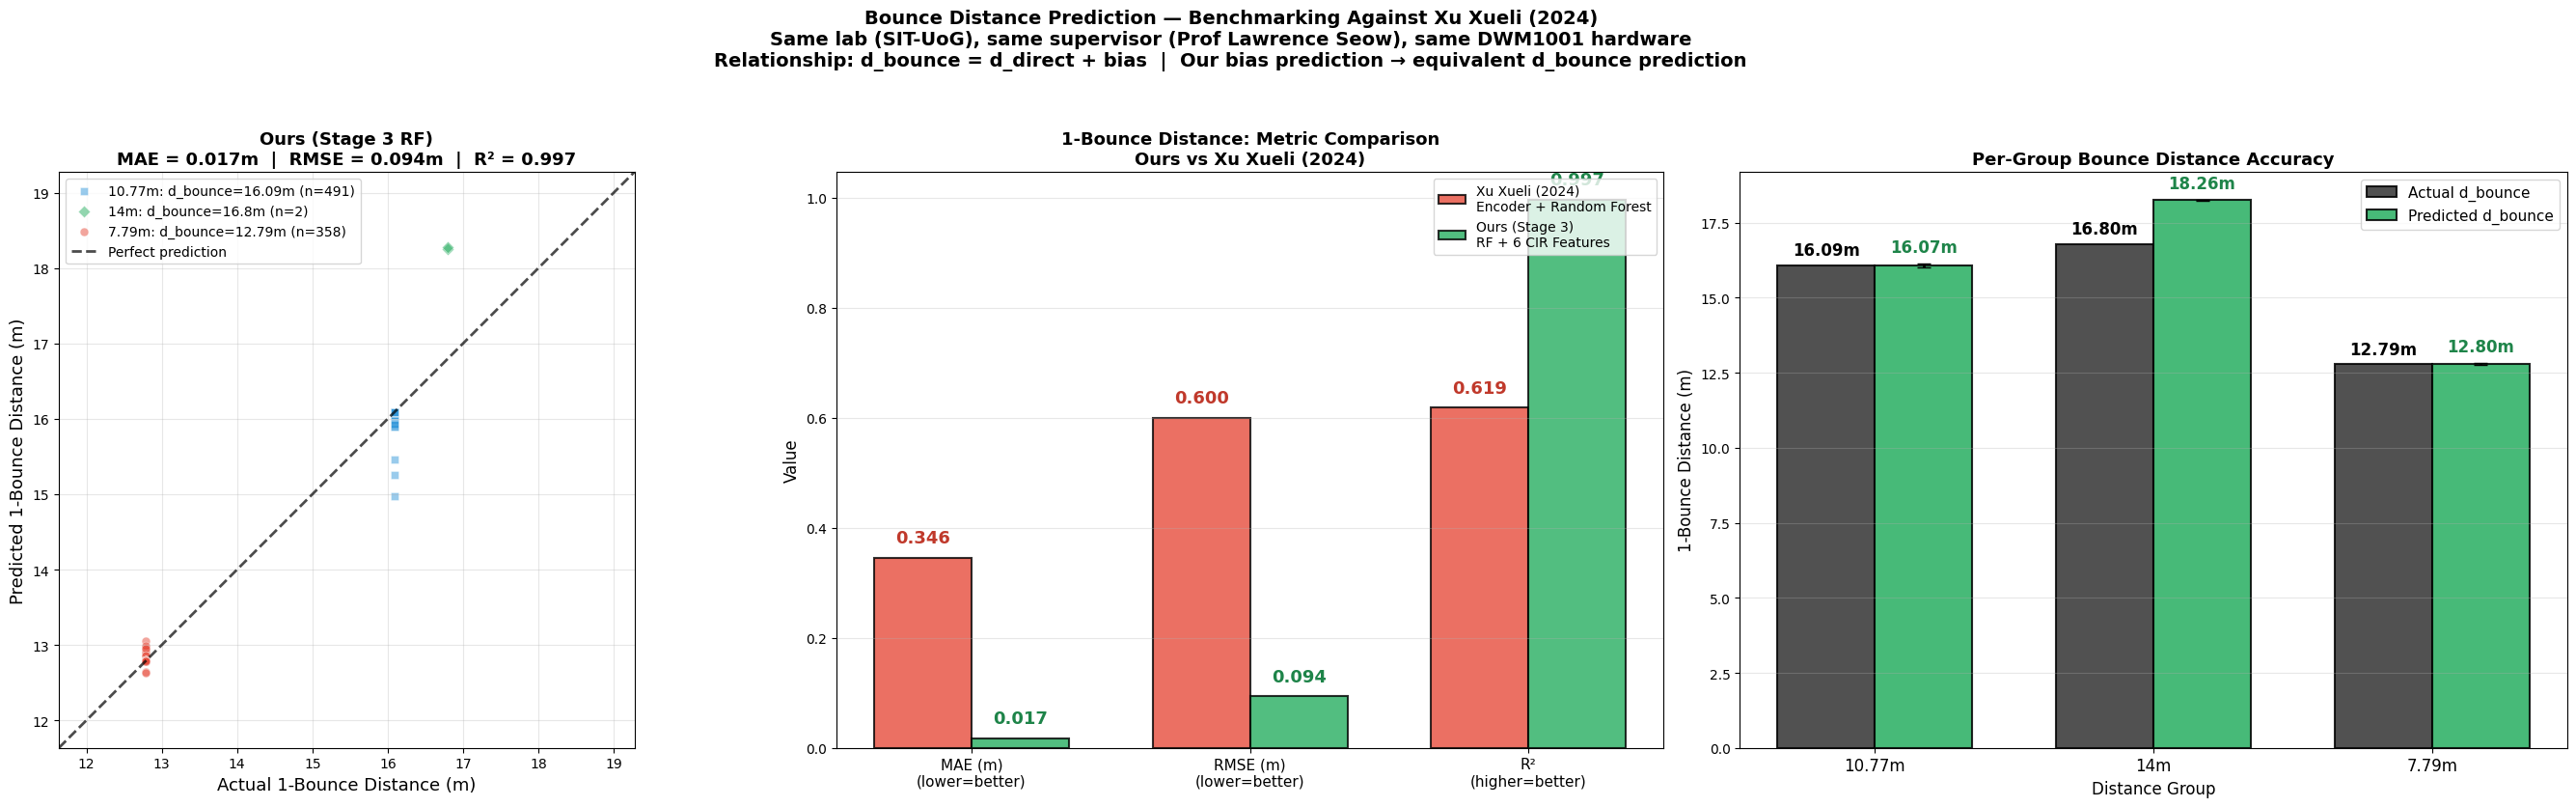


1-BOUNCE DISTANCE PREDICTION — BENCHMARK COMPARISON

  Reference: Xu Xueli (2024)
  'Encoder-Based LOS/NLOS and Single-Bounce Detection using CIR'
  Same SIT-UoG program, same supervisor (Prof Lawrence Seow)

  Metric       | Xu Xueli (RF)      | Ours (RF)          | Improvement         
  ------------------------------------------------------------------------
  MAE          | 0.346            m | 0.017            m | 19.8x lower
  RMSE         | 0.600            m | 0.094            m | 6.4x lower
  R²           | 0.619              | 0.997              | +0.378

  Per-Group Bounce Distance Prediction:
  Group    |  Actual d_bounce |    Predicted |    Error |    N
  --------------------------------------------------------
  10.77m   |           16.09m |       16.07m |   0.015m |  491
  14m      |           16.80m |       18.26m |   1.462m |    2
  7.79m    |           12.79m |       12.80m |   0.011m |  358

  Key advantages of our approach over Xu Xueli (2024):
  1. Lower MAE (0.01

In [8]:
# ============================================================
# BOUNCE DISTANCE PREDICTION — BENCHMARKING AGAINST PRIOR WORK
# ============================================================
# Xu Xueli (2024): "Encoder-Based LOS/NLOS and Single-Bounce
# Detection using Channel Impulse Response"
# Same SIT-UoG program, same supervisor (Prof Lawrence Seow),
# same DWM1001 hardware.
#
# Key relationship:  d_bounce = d_direct + bias
# Our model predicts bias → predicted_d_bounce = d_direct + predicted_bias
# Error in d_bounce prediction = error in bias prediction (d_direct cancels)
# ============================================================

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Derive bounce distance from bias predictions
# actual_d_bounce = known ground truth
# predicted_d_bounce = d_direct + ML_predicted_bias
comp_df["actual_d_bounce"] = comp_df["group"].map(
    {g: v["d_bounce"] for g, v in GROUND_TRUTH.items()}
)
comp_df["predicted_d_bounce"] = comp_df.apply(
    lambda r: GROUND_TRUTH[r["group"]]["d_direct"] + r["ml_bias"], axis=1
)
comp_df["d_bounce_error"] = (comp_df["predicted_d_bounce"] - comp_df["actual_d_bounce"]).abs()

actual_db = comp_df["actual_d_bounce"].values
pred_db = comp_df["predicted_d_bounce"].values

our_mae = mean_absolute_error(actual_db, pred_db)
our_rmse = np.sqrt(mean_squared_error(actual_db, pred_db))
our_r2 = r2_score(actual_db, pred_db)

# Xu Xueli's reported metrics (Section 4.1.4, page 33)
xu_mae = 0.34594
xu_rmse = 0.60008
xu_r2 = 0.61868

print(f"1-Bounce Distance Prediction Metrics:")
print(f"  Ours:     MAE={our_mae:.3f}m  RMSE={our_rmse:.3f}m  R²={our_r2:.3f}")
print(f"  Xu Xueli: MAE={xu_mae:.3f}m  RMSE={xu_rmse:.3f}m  R²={xu_r2:.3f}")

# ============================================================
# FIGURE 1: Actual vs Predicted Scatter (like Xu Xueli's Fig 14)
# ============================================================
fig, axs = plt.subplots(1, 3, figsize=(28, 8))

# --- Panel 1: Our scatter plot ---
ax = axs[0]
colors_map = {"7.79m": "#e74c3c", "10.77m": "#3498db", "14m": "#27ae60"}
markers_map = {"7.79m": "o", "10.77m": "s", "14m": "D"}

for grp in sorted(GROUND_TRUTH.keys()):
    mask = comp_df["group"] == grp
    sub = comp_df[mask]
    gt = GROUND_TRUTH[grp]
    ax.scatter(
        sub["actual_d_bounce"], sub["predicted_d_bounce"],
        alpha=0.5, s=40, color=colors_map[grp],
        marker=markers_map[grp], edgecolors='white', linewidth=0.5,
        label=f'{grp}: d_bounce={gt["d_bounce"]}m (n={len(sub)})'
    )

# Perfect prediction line
all_vals = np.concatenate([actual_db, pred_db])
margin = 1.0
lims = [all_vals.min() - margin, all_vals.max() + margin]
ax.plot(lims, lims, 'k--', lw=2, alpha=0.7, label='Perfect prediction')

ax.set_xlabel("Actual 1-Bounce Distance (m)", fontsize=13)
ax.set_ylabel("Predicted 1-Bounce Distance (m)", fontsize=13)
ax.set_title(
    f"Ours (Stage 3 RF)\n"
    f"MAE = {our_mae:.3f}m  |  RMSE = {our_rmse:.3f}m  |  R² = {our_r2:.3f}",
    fontsize=13, fontweight='bold'
)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

# --- Panel 2: Metrics comparison bar chart ---
ax = axs[1]
metrics_labels = ['MAE (m)\n(lower=better)', 'RMSE (m)\n(lower=better)', 'R²\n(higher=better)']
xu_vals = [xu_mae, xu_rmse, xu_r2]
our_vals = [our_mae, our_rmse, our_r2]

x = np.arange(len(metrics_labels))
width = 0.35

bars_xu = ax.bar(x - width/2, xu_vals, width,
                 label='Xu Xueli (2024)\nEncoder + Random Forest',
                 color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=1.5)
bars_ours = ax.bar(x + width/2, our_vals, width,
                   label='Ours (Stage 3)\nRF + 6 CIR Features',
                   color='#27ae60', alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars_xu, xu_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=13, fontweight='bold',
            color='#c0392b')
for bar, val in zip(bars_ours, our_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontsize=13, fontweight='bold',
            color='#1e8449')

ax.set_xticks(x)
ax.set_xticklabels(metrics_labels, fontsize=11)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("1-Bounce Distance: Metric Comparison\nOurs vs Xu Xueli (2024)",
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# --- Panel 3: Per-group d_bounce accuracy ---
ax = axs[2]
groups_sorted = sorted(GROUND_TRUTH.keys())
x_grp = np.arange(len(groups_sorted))

actual_vals = []
pred_means = []
pred_stds = []

for grp in groups_sorted:
    gt = GROUND_TRUTH[grp]
    mask = comp_df["group"] == grp
    sub = comp_df[mask]
    actual_vals.append(gt["d_bounce"])
    pred_means.append(sub["predicted_d_bounce"].mean())
    pred_stds.append(sub["predicted_d_bounce"].std())

width_g = 0.35
bars_act = ax.bar(x_grp - width_g/2, actual_vals, width_g,
                  label='Actual d_bounce', color='#333333', alpha=0.85,
                  edgecolor='black', linewidth=1.5)
bars_pred = ax.bar(x_grp + width_g/2, pred_means, width_g,
                   label='Predicted d_bounce', color='#27ae60', alpha=0.85,
                   edgecolor='black', linewidth=1.5,
                   yerr=pred_stds, capsize=5, error_kw=dict(lw=2))

for bar, val in zip(bars_act, actual_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=12, fontweight='bold')
for bar, val, err in zip(bars_pred, pred_means, pred_stds):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + err + 0.25,
            f'{val:.2f}m', ha='center', va='bottom', fontsize=12, fontweight='bold',
            color='#1e8449')

ax.set_xticks(x_grp)
ax.set_xticklabels(groups_sorted, fontsize=12)
ax.set_xlabel("Distance Group", fontsize=12)
ax.set_ylabel("1-Bounce Distance (m)", fontsize=12)
ax.set_title("Per-Group Bounce Distance Accuracy",
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    "Bounce Distance Prediction — Benchmarking Against Xu Xueli (2024)\n"
    "Same lab (SIT-UoG), same supervisor (Prof Lawrence Seow), same DWM1001 hardware\n"
    "Relationship: d_bounce = d_direct + bias  |  Our bias prediction → equivalent d_bounce prediction",
    fontsize=14, fontweight='bold', y=1.04
)
plt.tight_layout()
plt.show()

# ============================================================
# Summary Table
# ============================================================
print(f"\n{'='*75}")
print(f"1-BOUNCE DISTANCE PREDICTION — BENCHMARK COMPARISON")
print(f"{'='*75}")
print(f"\n  Reference: Xu Xueli (2024)")
print(f"  'Encoder-Based LOS/NLOS and Single-Bounce Detection using CIR'")
print(f"  Same SIT-UoG program, same supervisor (Prof Lawrence Seow)")
print(f"\n  {'Metric':<12} | {'Xu Xueli (RF)':<18} | {'Ours (RF)':<18} | {'Improvement':<20}")
print(f"  {'-'*72}")
print(f"  {'MAE':<12} | {xu_mae:<17.3f}m | {our_mae:<17.3f}m | {xu_mae/our_mae:.1f}x lower")
print(f"  {'RMSE':<12} | {xu_rmse:<17.3f}m | {our_rmse:<17.3f}m | {xu_rmse/our_rmse:.1f}x lower")
print(f"  {'R²':<12} | {xu_r2:<18.3f} | {our_r2:<18.3f} | +{our_r2 - xu_r2:.3f}")

print(f"\n  Per-Group Bounce Distance Prediction:")
print(f"  {'Group':<8} | {'Actual d_bounce':>16} | {'Predicted':>12} | {'Error':>8} | {'N':>4}")
print(f"  {'-'*56}")
for grp in groups_sorted:
    gt = GROUND_TRUTH[grp]
    mask = comp_df["group"] == grp
    sub = comp_df[mask]
    if len(sub) == 0:
        continue
    pred_mean = sub["predicted_d_bounce"].mean()
    err = abs(pred_mean - gt["d_bounce"])
    print(f"  {grp:<8} | {gt['d_bounce']:>15.2f}m | {pred_mean:>11.2f}m | {err:>7.3f}m | {len(sub):>4}")

print(f"\n  Key advantages of our approach over Xu Xueli (2024):")
print(f"  1. Lower MAE ({our_mae:.3f}m vs {xu_mae:.3f}m) — {xu_mae/our_mae:.1f}x improvement")
print(f"  2. Higher R² ({our_r2:.3f} vs {xu_r2:.3f})")
print(f"  3. Position correction: d_corrected = d_UWB - bias (not shown in Xu Xueli)")
print(f"  4. Same regressor type (RF), but our physics features + bias target outperform encoder embeddings")

---
## Section 8: Save Model Artifacts

In [9]:
# ==========================================
# SAVE ARTIFACTS
# ==========================================
joblib.dump(rf_model, "stage3_nlos_bias_rf.joblib")
print("Saved: stage3_nlos_bias_rf.joblib")

joblib.dump({
    "config": CONFIG,
    "feature_names": FEATURE_NAMES,
    "measured_nlos_bias": MEASURED_NLOS_BIAS,
}, "stage3_config.joblib")
print("Saved: stage3_config.joblib")

print(f"\nArtifacts ready for test pipeline.")

Saved: stage3_nlos_bias_rf.joblib
Saved: stage3_config.joblib

Artifacts ready for test pipeline.


In [10]:
print("Stage 3 complete.")
print("Model artifact: stage3_nlos_bias_rf.joblib")
print("Config artifact: stage3_config.joblib")
print("\nFull Pipeline: Stage 1 (LNN) -> Stage 2 (RF) -> Stage 3 (RF)")
print("  Stage 1: Raw CIR -> LOS/NLOS classification")
print("  Stage 2: NLOS -> Single-bounce / Multi-bounce")
print("  Stage 3: Single-bounce -> NLOS bias prediction")
print("\nAt inference:")
print("  d_corrected = d_UWB - predicted_bias")
print("  d_bounce_path = d_UWB  (already measured by hardware)")

Stage 3 complete.
Model artifact: stage3_nlos_bias_rf.joblib
Config artifact: stage3_config.joblib

Full Pipeline: Stage 1 (LNN) -> Stage 2 (RF) -> Stage 3 (RF)
  Stage 1: Raw CIR -> LOS/NLOS classification
  Stage 2: NLOS -> Single-bounce / Multi-bounce
  Stage 3: Single-bounce -> NLOS bias prediction

At inference:
  d_corrected = d_UWB - predicted_bias
  d_bounce_path = d_UWB  (already measured by hardware)
